# Landmarks Path Computation
In this notebook, we train emotion models using the CK+ dataset.
- Read landmarks files and convert it to a normalized space.
- TODO: PCA to avoid unnecessary landmarks
- Based on the normalized landmarks, compute its patch regresssion.
- 

## Function to read and pre-process features from a file
The dataset contains landmarks computed using AAM. These landmarks are stored as a sequence of (x \n y \n) floats dots. Each frame has its own landmark file. To achieve a normalized feature set, it is set the nose as the reference point and the distance between the eyes as the reference size. For each landmark, the final feature is its distance to the reference point divided by the reference size.

In [1]:
using Distances
function readLandmarksFile(filename)
    # println("Getting features from: ", filename)
    
    # Database parser
    dots = map((x)->parse(x), split(readall(filename), ['\n', ' '], limit=0, keep=false));
    getLandmarkPoint(id) = [dots[id*2-1], dots[id*2]];
    
    # Reference Point: nose
    referenceID = 34
    referencePoint = getLandmarkPoint(referenceID)
    
    # Reference Size: distance between eyes
    referenceSize = evaluate(Euclidean(), getLandmarkPoint(40), getLandmarkPoint(43))
    if referenceSize < 1.0 error("Distance between eyes less than one.") end
    
    # Normalized vector
    normalizedVector = []
    for id = 1:round(Int,(length(dots) / 2))
        if id == referenceID; continue end
        append!(normalizedVector, (referencePoint - getLandmarkPoint(id)) / referenceSize)
    end
    
    return normalizedVector
end;

## Function to perform patch regression over the landmarks
Using the above function, all the landmarks from a video sequence are read and normalized. Then, for each landmark trajectory, it is computed its patch regression. The regression uses a second order polinomial function: a + bx + cx^2. The resulting vector contains the parameters [x0,xt,a,b,c] for each landmark patch.

In [2]:
# returns patch_xy[file][landmark*2]
function getPatchFeatures(dir)
    landmarks4frame = []
    for f = readdir("$dir")
        push!(landmarks4frame, readLandmarksFile("$dir/$f"))
    end
    return landmarks4frame
end;

In [3]:
# returns the (x y) patch for a given landmark
function splitXY(patch, landmark)
    x, y = Float64[], Float64[]
    for file = 1:round(Int, length(patch))
        push!(x, patch[file][landmark*2-1])
        push!(y, patch[file][landmark*2])
    end
    return x, y
end;

In [4]:
# return abcd (cubic) params for a given (x, y) patch
using LsqFit
function cubicRegression(x, y)
    model(x, p) = p[1] + p[2] * x + p[3] * x .^ 2 + p[4] * x .^ 3;
    fit = curve_fit(model, x, y, [0.,0.,0.,0.]);
    return fit.param
end;
function squareRegression(x, y)
    model(x, p) = p[1] + p[2] * x + p[3] * x .^ 2;
    fit = curve_fit(model, x, y, [0.,0.,0.]);
    return fit.param
end;

In [5]:
using Gadfly
function drawCubicCurve(x, y, param, title="no title")
    plot(layer(x=x, y=y, Geom.point, order=1),
         layer((x)->param[1] + param[2] * x + param[3] * x .^ 2 + param[4] * x .^ 3, minimum(x), maximum(x)),
         Guide.title(title))
end;
function drawSquareCurve(x, y, param, title="no title")
    plot(layer(x=x, y=y, Geom.point, order=1),
         layer((x)->param[1] + param[2] * x + param[3] * x .^ 2, minimum(x), maximum(x)),
         Guide.title(title))
end;

In [6]:
# performs regression for each landmark on a video clip
# returns [x0, xt, a, b, c] * lenght(landmarks), i.e. SVM ready
function landmarksRegressionParams(dir, debug=false)
    abc = []
    patch = getPatchFeatures(dir)
    for landmark = 1:floor(Int, length(patch[1]) / 2)
        x, y = splitXY(patch, landmark)
        p = []
        try
            p = squareRegression(x, y)
        catch
            warn("Landmark $landmark: Skipping regression due to an awesome error while performing curve fitting")
            p = [0.,0.,0.]
        finally
            push!(abc, minimum(x))
            push!(abc, maximum(x))
            append!(abc, p)
            if debug display(drawSquareCurve(x, y, p, "landmark: $landmark")) end            
        end
    end
    return abc
end;

In [7]:
p = landmarksRegressionParams("/home/data/ckplus/Landmarks/S100/001")
# p = landmarksRegressionParams("/home/data/ckplus/Landmarks/S010/003")
# dir = "/home/data/ckplus/Landmarks/$person/$shot"

335-element Array{Any,1}:
   1.65455   
   1.71584   
  44.6662    
 -52.8175    
  15.8939    
   1.62076   
   1.68077   
  18.8591    
 -23.2066    
   7.27266   
   1.5593    
   1.63818   
  10.8141    
   ⋮         
   2.99157   
   2.84748   
  -0.0334427 
   0.00023093
  -0.525601  
  15.7533    
 230.174     
   0.218695  
   0.342725  
   0.0430604 
  -3.04394   
   2.18615   

In [8]:
using Gadfly
function drawLandmarksCurves(param)     # TODO - a not so hardcoded revision
    layers = Array{Gadfly.Layer,1}[]
    for i in 1:floor(Int, length(param) / 5)
        x0, xt, a, b, c = param[i*5-4], param[i*5-3], param[i*5-2], param[i*5-1], param[i*5]
        push!(layers, layer((x)->a+b*x+c*x.^2, x0, xt))
    end
    plot( layers[1], layers[2], layers[3], layers[4], layers[5], layers[6], layers[7], layers[8], layers[9], layers[10], layers[11], layers[12], layers[13], layers[14], layers[15], layers[16], layers[17], layers[18], layers[19], layers[20], layers[21], layers[22], layers[23], layers[24], layers[25], layers[26], layers[27], layers[28], layers[29], layers[30], layers[31], layers[32], layers[33], layers[34], layers[35], layers[36], layers[37], layers[38], layers[39], layers[40], layers[41], layers[42], layers[43], layers[44], layers[45], layers[46], layers[47], layers[48], layers[49], layers[50], layers[51], layers[52], layers[53], layers[54], layers[55], layers[56], layers[57], layers[58], layers[59], layers[60], layers[61], layers[62], layers[63], layers[64], layers[65], layers[66], layers[67], Guide.title("Facial Landmarks Patchs"))
end;

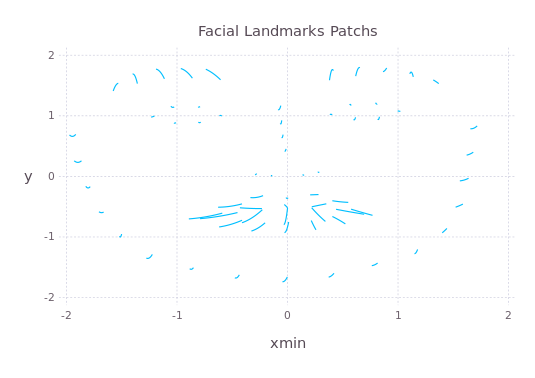

In [9]:
drawLandmarksCurves(p)

# Function to iterate over the CK+ dataset
For each sample, read the landmarks and the emotion result files. Using the above functions, the landmarks are transformed to an array of regression parameters. To perform the SVM trainning, the trainning matrix is composed by the regression parameters, where each row represent a sample video. In the same manner, the result matrix (for trainning) is composed by the emotion ID for the respective sample in the trainning matrix. So, for SVM trainning there are two matrixes, MTrainning: samples x (landmarks * regression_params), MTResults: samples x 1.

In [10]:
# read the sample file containing Emotion or FACS codes
function readResultFile(dir)
    results = []
    for a in readdir(dir)
        filename = "$dir/$a"
        append!(results, map((x)->convert(Int, parse(x)), split(readall(filename), ['\n', ' '], limit=0, keep=false)))
    end
    return(results)
end;
readResultFile("/home/data/ckplus/Emotion/S005/001")

1-element Array{Any,1}:
 3

In [30]:
# iterate over all samples to mount the trainning matrix for svm: X <samples> x <landmarks * regression_params>
# returns also the path "$subject/$sample" referencing each sample in X
function parseSVMTrainingX(dir)
    landmarksDir = "$dir/Landmarks"
    X, Path = Matrix, []
    first, c = true, 0
    for subjectDir = readdir(landmarksDir), sampleDir = readdir("$landmarksDir/$subjectDir")
        c += 1
        if (c % 100 == 0) println("$c") end
        row = []
        try
            row = landmarksRegressionParams("$landmarksDir/$subjectDir/$sampleDir")
        catch
            warn("$c: Skipping due to some bizarre error while loading landmarks regression parameters.")
            continue
        end
        if !first
            X = vcat(X, reshape(row, 1, size(row)[1]))
        else
            X = reshape(row, 1, size(row)[1])
            first = false
        end
        push!(Path, "$subjectDir/$sampleDir")
    end
    return X, Path
end
X, P = parseSVMTrainingX("/home/data/ckplus");

0.001557923441399917 (predicted_residual) >
0.001557923441399916 (residual) + 2.168404344971009e-19 (eps)


100


0.0015294840367033441 (predicted_residual) >
0.0015294840367033435 (residual) + 2.168404344971009e-19 (eps)
4.234172740529432e-7 (predicted_residual) >
3.999182640009279e-7 (residual) + 5.293955920339377e-23 (eps)
3.6977921460262776e-7 (predicted_residual) >
3.6977842723564926e-7 (residual) + 5.293955920339377e-23 (eps)
1.0198107162043539e-9 (predicted_residual) >
8.276141378370133e-10 (residual) + 2.0679515313825692e-25 (eps)
1.9430418844491996e-5 (predicted_residual) >
1.9430312308963642e-5 (residual) + 3.3881317890172014e-21 (eps)


200


4.430542572763326e-7 (predicted_residual) >
3.5104788717020695e-7 (residual) + 5.293955920339377e-23 (eps)
0.001147596165395189 (predicted_residual) >
0.0011475961653951883 (residual) + 2.168404344971009e-19 (eps)
7.495394329371154e-9 (predicted_residual) >
6.35277923127338e-9 (residual) + 1.6543612251060553e-24 (eps)
8.888489423428942e-9 (predicted_residual) >
6.926374952842766e-9 (residual) + 1.6543612251060553e-24 (eps)
1.9235731437968274e-9 (predicted_residual) >
4.382545052905591e-10 (residual) + 4.1359030627651384e-25 (eps)
7.081271774101576e-10 (predicted_residual) >
3.8173200146692075e-10 (residual) + 1.0339757656912846e-25 (eps)
5.343473613196792e-10 (predicted_residual) >
1.297106739017063e-10 (residual) + 1.0339757656912846e-25 (eps)
1.4296381341226259e-11 (predicted_residual) >
1.4295053813235453e-11 (residual) + 1.6155871338926322e-27 (eps)
2.8753400445053855e-9 (predicted_residual) >
2.7755603592186008e-9 (residual) + 4.1359030627651384e-25 (eps)
2.7531277325847847e-9 (pr

300


8.9738471153641e-5 (predicted_residual) >
8.973839072853483e-5 (residual) + 1.3552527156068805e-20 (eps)
3.390967930629293e-6 (predicted_residual) >
3.0368401124513785e-6 (residual) + 4.235164736271502e-22 (eps)
2.9001525203243127e-6 (predicted_residual) >
2.685801592200524e-6 (residual) + 4.235164736271502e-22 (eps)
2.5588937436908338e-6 (predicted_residual) >
2.5587606224300374e-6 (residual) + 4.235164736271502e-22 (eps)
1.2334930460592452e-9 (predicted_residual) >
1.2326673968168132e-9 (residual) + 2.0679515313825692e-25 (eps)
1.6785968352886283e-5 (predicted_residual) >
1.678596835121486e-5 (residual) + 3.3881317890172014e-21 (eps)
2.0610994024303835e-5 (predicted_residual) >
2.060109179108311e-5 (residual) + 3.3881317890172014e-21 (eps)
0.00010756292427752985 (predicted_residual) >
0.00010756292415505498 (residual) + 1.3552527156068805e-20 (eps)
9.51355755866774e-6 (predicted_residual) >
9.38398077916439e-6 (residual) + 1.6940658945086007e-21 (eps)
1.0468159695501117e-5 (predicted

400


9.689776598736821e-11 (predicted_residual) >
8.948132533862115e-11 (residual) + 1.2924697071141057e-26 (eps)
1.0518504807583791e-10 (predicted_residual) >
9.690371714379994e-11 (residual) + 1.2924697071141057e-26 (eps)
1.057682967955684e-10 (predicted_residual) >
1.046463426864003e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0601507396367237e-10 (predicted_residual) >
1.0501687689858915e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0385317764325274e-10 (predicted_residual) >
1.0305973003821524e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0372639311972102e-10 (predicted_residual) >
1.0305648154876176e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0276816626817959e-10 (predicted_residual) >
1.0190607658800393e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0355885094116972e-10 (predicted_residual) >
1.0141144316377561e-10 (residual) + 1.2924697071141057e-26 (eps)
9.37349693718086e-11 (predicted_residual) >
8.66243540287484e-11 (residual) + 1.2924697071141057e-26 (eps)
3.57547859

500


1.6837930219684986e-6 (predicted_residual) >
1.5347958111671472e-6 (residual) + 2.117582368135751e-22 (eps)
1.4416353915882134e-6 (predicted_residual) >
1.439603241725903e-6 (residual) + 2.117582368135751e-22 (eps)
1.4391254937030525e-6 (predicted_residual) >
1.4391250795637721e-6 (residual) + 2.117582368135751e-22 (eps)
3.4233958809587176e-8 (predicted_residual) >
3.4233876510835314e-8 (residual) + 6.617444900424222e-24 (eps)
1.1377298549779726e-6 (predicted_residual) >
1.1120757605120643e-6 (residual) + 2.117582368135751e-22 (eps)
1.1470516841008527e-6 (predicted_residual) >
1.1377539155565412e-6 (residual) + 2.117582368135751e-22 (eps)
6.165609718906536e-6 (predicted_residual) >
4.521833198283339e-6 (residual) + 8.470329472543003e-22 (eps)
3.982639782662421e-6 (predicted_residual) >
3.6734156399575105e-6 (residual) + 8.470329472543003e-22 (eps)
4.591791699234754e-6 (predicted_residual) >
3.784771921921588e-6 (residual) + 8.470329472543003e-22 (eps)
5.094468961947176e-6 (predicted_re

In [ ]:
using RegERMs
function trainCKPlus(dir, debug = false)
    landmarksDir = "$dir/Landmarks"
    emotionDir = "$dir/Emotion"
    facsDir =  "$dir/FACS"
end

trainCKPlus("/home/data/ckplus", true)

In [ ]:
# "/home/data/ckplus/Emotion/S005/001/S005_001_00000011_emotion.txt"
println(593 * 67 * 5)
println(67 * 5)

In [31]:
size(X)

(592,335)

In [32]:
P[1:10]

10-element Array{Any,1}:
 "S005/001"
 "S010/001"
 "S010/002"
 "S010/003"
 "S010/004"
 "S010/005"
 "S010/006"
 "S011/001"
 "S011/002"
 "S011/003"

LoadError: LoadError: UnicodeError: invalid character index
while loading In[17], in expression starting on line 1

In [ ]:
drawLandmarksCurves(b[1])